In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import math
# read the file into a list of lines and print to separate files for different outputs
link_to_files = "regression_results/"
for d in [0, 1, 2]:
    for version in ["basic", "ensemble", "HAT" #Baselines
                    #"randomsearch", "asha",
                   ]: #Search algorithms
        with open(link_to_files+"results_extended_"+version+"_"+str(d)+".txt",'r') as f:
            lines = f.read().split("\n")
        
        try:
            os.mkdir(link_to_files+version)
        except FileExistsError:
            pass
        output_file_perf = open(link_to_files+version+"/Performance_Output_"+ str(d)+".txt", "w+")
        output_file_retrainings = open(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt", "w+")
        output_file_update = open(link_to_files+version+"/Update_Output_"+ str(d)+".txt", "w+")
        output_file_models = open(link_to_files+version+"/Models_Output_"+ str(d)+".txt", "w+")
        word_perf = 'Test batch'
        word_drift = 'Change detected'
        word_nondrift = 'No drift but'
        word_update = 'Online model is updated'
        word_model = 'Current model is'
        word_imodel = 'Initial model is'
        # iterate over lines, and print out line numbers which contain the word of interest.
        for j,line in enumerate(lines):
            if word_perf in line: # or word in line.split() to search for full word
                print("{}".format(line), file=output_file_perf)
            if word_drift in line:
                print("{}".format(line), file=output_file_retrainings)
            if word_update in line:
                print("{}".format(line), file=output_file_update)
            if word_nondrift in line:
                print("{}".format(line), file=output_file_retrainings)
            if (word_model in line) or (word_imodel in line):
                print("{}".format(line), file=output_file_models)
        output_file_perf.close()
        output_file_retrainings.close()
        output_file_update.close()
        output_file_models.close()
        
#Read data from the output files
# Get test scores and batch numbers
results={}
retrainings={}
models={}
for d in [0, 1, 2]:  # data streams
    results["AutOL_Data_" + str(d)]={}
    retrainings["AutOL_Data_" + str(d)] = {}
    models["AutOL_Data_" + str(d)] = {}
    for version in ["basic", "ensemble", "HAT" #Baselines
                    #"randomsearch", "asha"
                   ]: #Search algorithms
        #Get performance
        read_perf = pd.read_table(link_to_files+version+"/Performance_Output_"+ str(d)+".txt", header=None, sep=' ')
        results["AutOL_Data_" + str(d)][version] = (read_perf.iloc[:, [3, 6]])
        results["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Test score']
        # results["AutOL_Data_" + str(d)][version]['Test score'] = results["AutOL_Data_" + str(d)][version]['Test score'].str.rstrip('%').astype('float') / 100.0
        #Get retraining points and types - No : no drift training point, Change: drift training point
        if os.path.getsize(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt") > 0:
            read_retraining = pd.read_table(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt", header=None, sep=' ')
            retrainings["AutOL_Data_" + str(d)][version] = read_retraining.iloc[:, [5,0]]
            retrainings["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Type']
        #Get model switch to ensemble/model store or AutOL output
        if version not in {"basic", "HAT", "LeverageBagging", "randomsearch", "asha"} and os.path.getsize(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt") > 0:
            read_update = pd.read_table(link_to_files+version+"/Update_Output_"+ str(d)+".txt", header=None, sep=' ', names=list(range(8)))
            retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]
            if version == "modelstore":
                retrainings["AutOL_Data_" + str(d)][version]['Model update'] = retrainings["AutOL_Data_" + str(d)][version]['Model update'].shift(5)
                retrainings["AutOL_Data_" + str(d)][version]['Model update'].replace(np.nan, "AutoML", inplace=True)
                retrainings["AutOL_Data_" + str(d)][version].reset_index(drop=True, inplace=True)
        #Get models
        models["AutOL_Data_" + str(d)][version]={}
        models["AutOL_Data_" + str(d)][version]['model']=[]
        if version not in {"HAT", "LeverageBagging", "randomsearch", "asha"} and os.path.getsize(link_to_files+version+"/Models_Output_"+ str(d)+".txt") > 0:
            for line in range(0,len(retrainings["AutOL_Data_" + str(d)][version])+1):
                read_models = pd.read_table(link_to_files+version+"/Models_Output_"+ str(d)+".txt", header=None, sep=' ', nrows = 1, skiprows = line)
                
                try:
                    model_string = str(read_models.iloc[0,3:9]).split('PreviousImputer')[1].split(' and')[0].split("|")[-1].strip("\n5")
                except:
                    model_string = str(read_models.iloc[0,3:9]).split(' and')[0].split("|")[-1].strip("\n5")
                temp_model = "".join(i for i in model_string if i.isalpha())
                models["AutOL_Data_" + str(d)][version]['model'].append(temp_model)
                

/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_1275/1139046932.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]
/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_1275/1139046932.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]
/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_1275/1139046932.py:71

In [129]:
# #new basic version
# version = "basic_new"
# for d in [0, 1, 2]:
#         with open(link_to_files+"results_"+version+"_"+str(d)+".txt",'r') as f:
#             lines = f.read().split("\n")
#         output_file_perf = open(link_to_files+version+"/Performance_Output_"+ str(d)+".txt", "w")
#         output_file_retrainings = open(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt", "w")
#         output_file_update = open(link_to_files+version+"/Update_Output_"+ str(d)+".txt", "w")
#         output_file_models = open(link_to_files+version+"/Models_Output_"+ str(d)+".txt", "w")
#         word_perf = 'Test batch'
#         word_drift = 'Change detected'
#         word_nondrift = 'No drift but'
#         word_update = 'Online model is'
#         word_model = 'Current model is'
#         word_imodel = 'Initial model is'
#         # iterate over lines, and print out line numbers which contain the word of interest.
#         for j,line in enumerate(lines):
#             if word_perf in line: # or word in line.split() to search for full word
#                 print("{}".format(line), file=output_file_perf)
#             if word_drift in line:
#                 print("{}".format(line), file=output_file_retrainings)
#             if word_update in line:
#                 print("{}".format(line), file=output_file_update)
#             if word_nondrift in line:
#                 print("{}".format(line), file=output_file_retrainings)
#             if (word_model in line) or (word_imodel in line):
#                 print("{}".format(line), file=output_file_models)
#         output_file_perf.close()
#         output_file_retrainings.close()
#         output_file_update.close()
#         output_file_models.close()  
        
# for d in [0, 1,2]:
#         #Get performance
#         read_perf = pd.read_table(link_to_files+version+"/Performance_Output_"+ str(d)+".txt", header=None, sep=' ')
#         results["AutOL_Data_" + str(d)][version] = (read_perf.iloc[:, [3, 6]])
#         results["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Test score']
#         results["AutOL_Data_" + str(d)][version]['Test score'] = results["AutOL_Data_" + str(d)][version]['Test score'].str.rstrip('%').astype('float') / 100.0
#         #Get retraining points and types - No : no drift training point, Change: drift training point
#         if os.path.getsize(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt") > 0:
#             read_retraining = pd.read_table(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt", header=None, sep=' ')
#             retrainings["AutOL_Data_" + str(d)][version] = read_retraining.iloc[:, [5,0]]
#             retrainings["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Type']
#         #Get model switch to ensemble/model store or AutOL output
#         read_update = pd.read_table(link_to_files+version+"/Update_Output_"+ str(d)+".txt", header=None, sep=' ', names=list(range(8)))
#         retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [5]]
#         #Get models
#         models["AutOL_Data_" + str(d)][version]={}
#         models["AutOL_Data_" + str(d)][version]['model']=[]
#         if version not in {"HAT", "LeverageBagging", "randomsearch", "asha"} and os.path.getsize(link_to_files+version+"/Models_Output_"+ str(d)+".txt") > 0:
#             for line in range(0,len(retrainings["AutOL_Data_" + str(d)][version])+1):
#                 read_models = pd.read_table(link_to_files+version+"/Models_Output_"+ str(d)+".txt", header=None, sep=' ', nrows = 1, skiprows = line)
#                 models["AutOL_Data_" + str(d)][version]['model'].append(read_models.iloc[0,3])
      
    

In [2]:
def make_marker_array(a,e,choice):
    b= a[choice]
    c = list(b['Batch number'])
    r = []
    for j in c:
        i = math.ceil(j/1000)*1000
        r.append(i)
    both = set(r).intersection(e)
    e=list(e)
    markon = [e.index(x) for x in both]
    return markon

/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_9363/3034188458.py:113: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[d].show()


<Figure size 1800x1440 with 0 Axes>

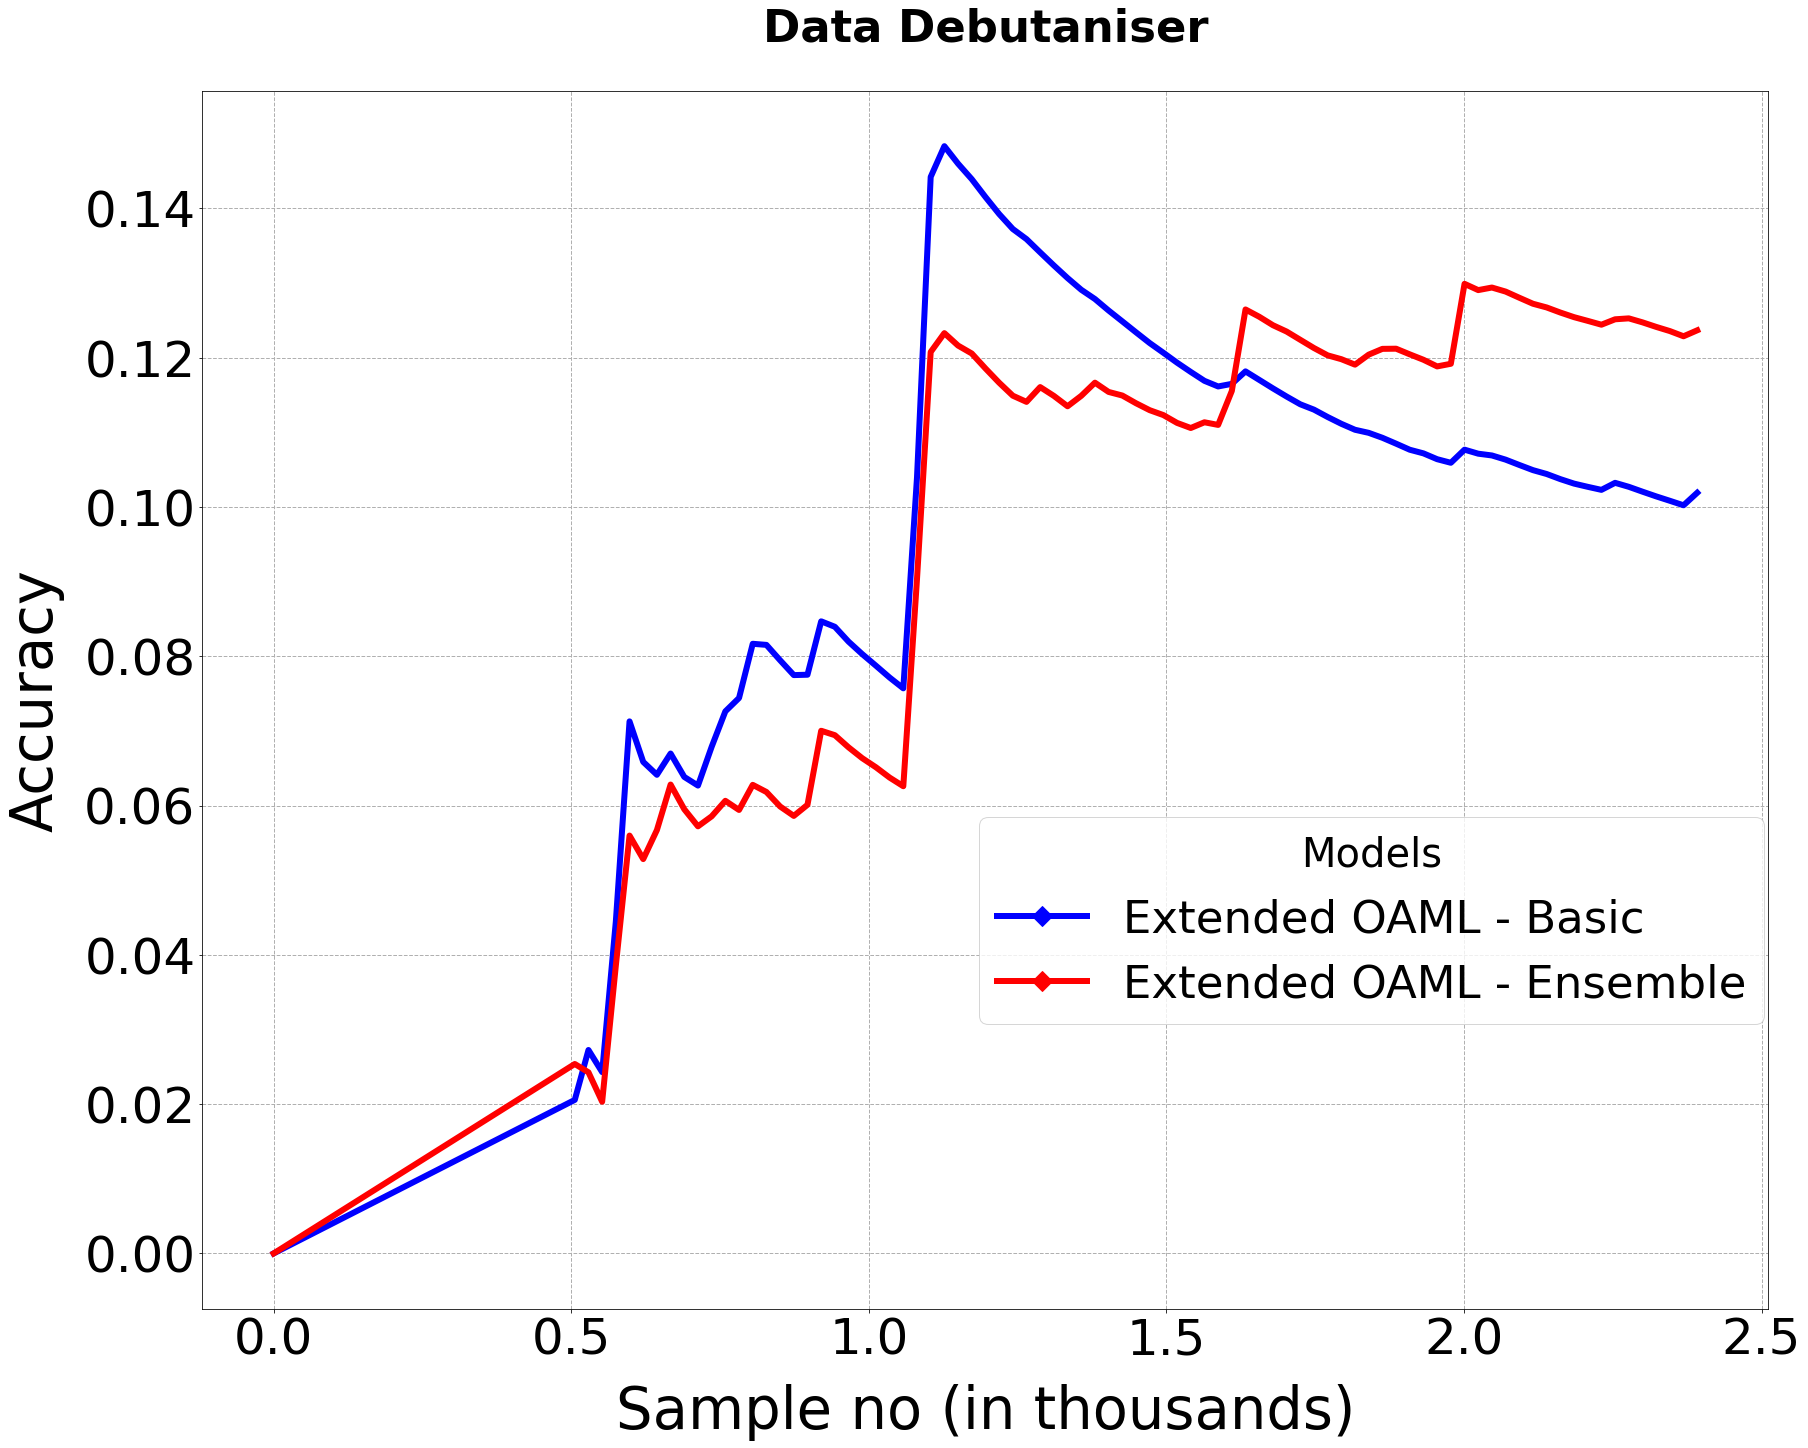

In [128]:
#Plot-1 Performance
import matplotlib
import math

figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

# data_names = ["Electricity", "Airlines",  "IMDB", "Vehicle", "SEA - High Abrupt Drift", "HYPERPLANE - High Gradual Drift",
#               "SEA - High Mixed Drift"]

data_names = ["Catalyst Activation", "Sulfur",  "Debutaniser"]


def make_marker_array(a,e,choice):
    b= a[choice]
    c = list(b['Batch number'])
    r = []
    for j in c:
        i = math.ceil(j/1000)*1000
        r.append(i)
    both = set(r).intersection(e)
    e=list(e)
    markon = [e.index(x) for x in both]
    return markon
for d in [2]:
    plt.rc('font', size=40)          # controls default text sizes
    plt.rc('axes', titlesize=40, titleweight = 'bold')     # fontsize of the axes title
    plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=50)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=50)    # fontsize of the tick labels
    plt.rc('legend', fontsize=40)    # legend fontsize
    plt.rc('figure', titlesize=40, titleweight = 'bold')  # fontsize of the figure title


    #plt.rcParams["figure.figsize"] = (45,20)  #real data scale 0,1,3
    plt.rcParams["figure.figsize"] = (25,20)  #art data scale  4,5,6
    plt.rcParams["axes.labelsize"] = ('x-large')
    figs[d]=plt.figure()
    figs[d], ax = plt.subplots(1, 1, sharex='col', sharey='row', constrained_layout=True)
    
    ax.set_title('Data '+data_names[int(d)], fontsize=45, pad=50)
    ax.set_xlabel("Sample no (in thousands)", labelpad=20)
    ax.set_ylabel("Accuracy", labelpad=20)

    ax.grid(linestyle='--', linewidth=1)
    ax.set_facecolor("white")

    #ax.set_title('AutOL Prequential Performance - Data '+data_names[int(d)], fontsize=45)

    ### Marker basic
    a = retrainings['AutOL_Data_'+str(d)]
    e = results["AutOL_Data_" + str(d)]['basic']['Batch number']
    markonb = make_marker_array(a,e,'basic')
    e = results["AutOL_Data_" + str(d)]['ensemble']['Batch number']
    markone = make_marker_array(a,e,'ensemble')


    ##############################################################

    #Plot performance lines of each version
    # basic
    l0 = ax.plot(results["AutOL_Data_" + str(d)]['basic']['Batch number']/1000,
                    results["AutOL_Data_" + str(d)]['basic']['Test score'],
                    ms = 14, marker='D', markeredgecolor='b', markevery=markonb,
                    label='Extended OAML - Basic', lw=6, color='b')
    
    # l0_1 = ax.plot(results["AutOL_Data_" + str(d)]['basic_new']['Batch number']/1000,
    #                 results["AutOL_Data_" + str(d)]['basic_new']['Test score'],
    #                 ms = 14, marker='D', markeredgecolor='black', markevery=markonb,
    #                 label='OAML - Basic updated', lw=6, color='black')
    
    #ensemble
    l1 = ax.plot(results["AutOL_Data_" + str(d)]['ensemble']['Batch number']/1000,
                    results["AutOL_Data_" + str(d)]['ensemble']['Test score'],
                    ms = 14, marker='D', markeredgecolor='r', markevery=markone,
                    label='Extended OAML - Ensemble', lw=6, color='r')
  
    
#     #Plot performance lines of baselinse
#     #HAT
#     l4 = ax.plot(results["AutOL_Data_" + str(d)]['HAT']['Batch number']/1000,
#                     results["AutOL_Data_" + str(d)]['HAT']['Test score'],
#                     #ms = 12, marker='D', markeredgecolor='black', markevery=markonh,
#                     label='HAT', lw=6, color='black')
#     #Leverage Bagging
#     l5 = ax.plot(results["AutOL_Data_" + str(d)]['LeverageBagging']['Batch number']/1000,
#                     results["AutOL_Data_" + str(d)]['LeverageBagging']['Test score'],
#                     #ms = 12, marker='D', markeredgecolor='grey', markevery=markonl,
#                     label='Leverage Bagging', lw=6, color='black', linestyle='dashed')
#     #ChaCha
#     l5 = ax.plot(results["AutOL_Data_" + str(d)]['chacha']['Batch number']/1000,
#                     results["AutOL_Data_" + str(d)]['chacha']['Test score'],
#                     #ms = 12, marker='D', markeredgecolor='grey', markevery=markonl,
#                     label='ChaCha', lw=6, color='orange', linestyle='dashed')


    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels,
               loc='lower right',  #0,3,4,5,6
               #loc='upper right', #airlines - 1
               bbox_to_anchor=(1,0.23),  #mixed data - 6
               ncol=1,
               borderaxespad=0.1,
               title="Models",
               prop={'size': 45})

    #plt.yticks(np.arange(results["AutOL_Ensemble_Data_" + str(d)]['Test score'], results["AutOL_Ensemble_Data_" + str(d)]['Test score']+0.1, 0.1))

    plt.plot()
    figs[d].show()
    figs[d].savefig(link_to_files+"/New basic oaml performance comparison"+str(d)+".png")
    

In [131]:
a = retrainings['AutOL_Data_'+str(2)]
e = results["AutOL_Data_" + str(d)]['modelstore']['Batch number']
b= a['modelstore']
c = list(b['Batch number'])
r = []
for j in c:
    i = math.ceil(j/1000)*1000
    r.append(i)
both = set(r).intersection(e)
e=list(e)
[e.index(x) for x in both]


KeyError: 'modelstore'

/home/bcelik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 3240x1440 with 0 Axes>

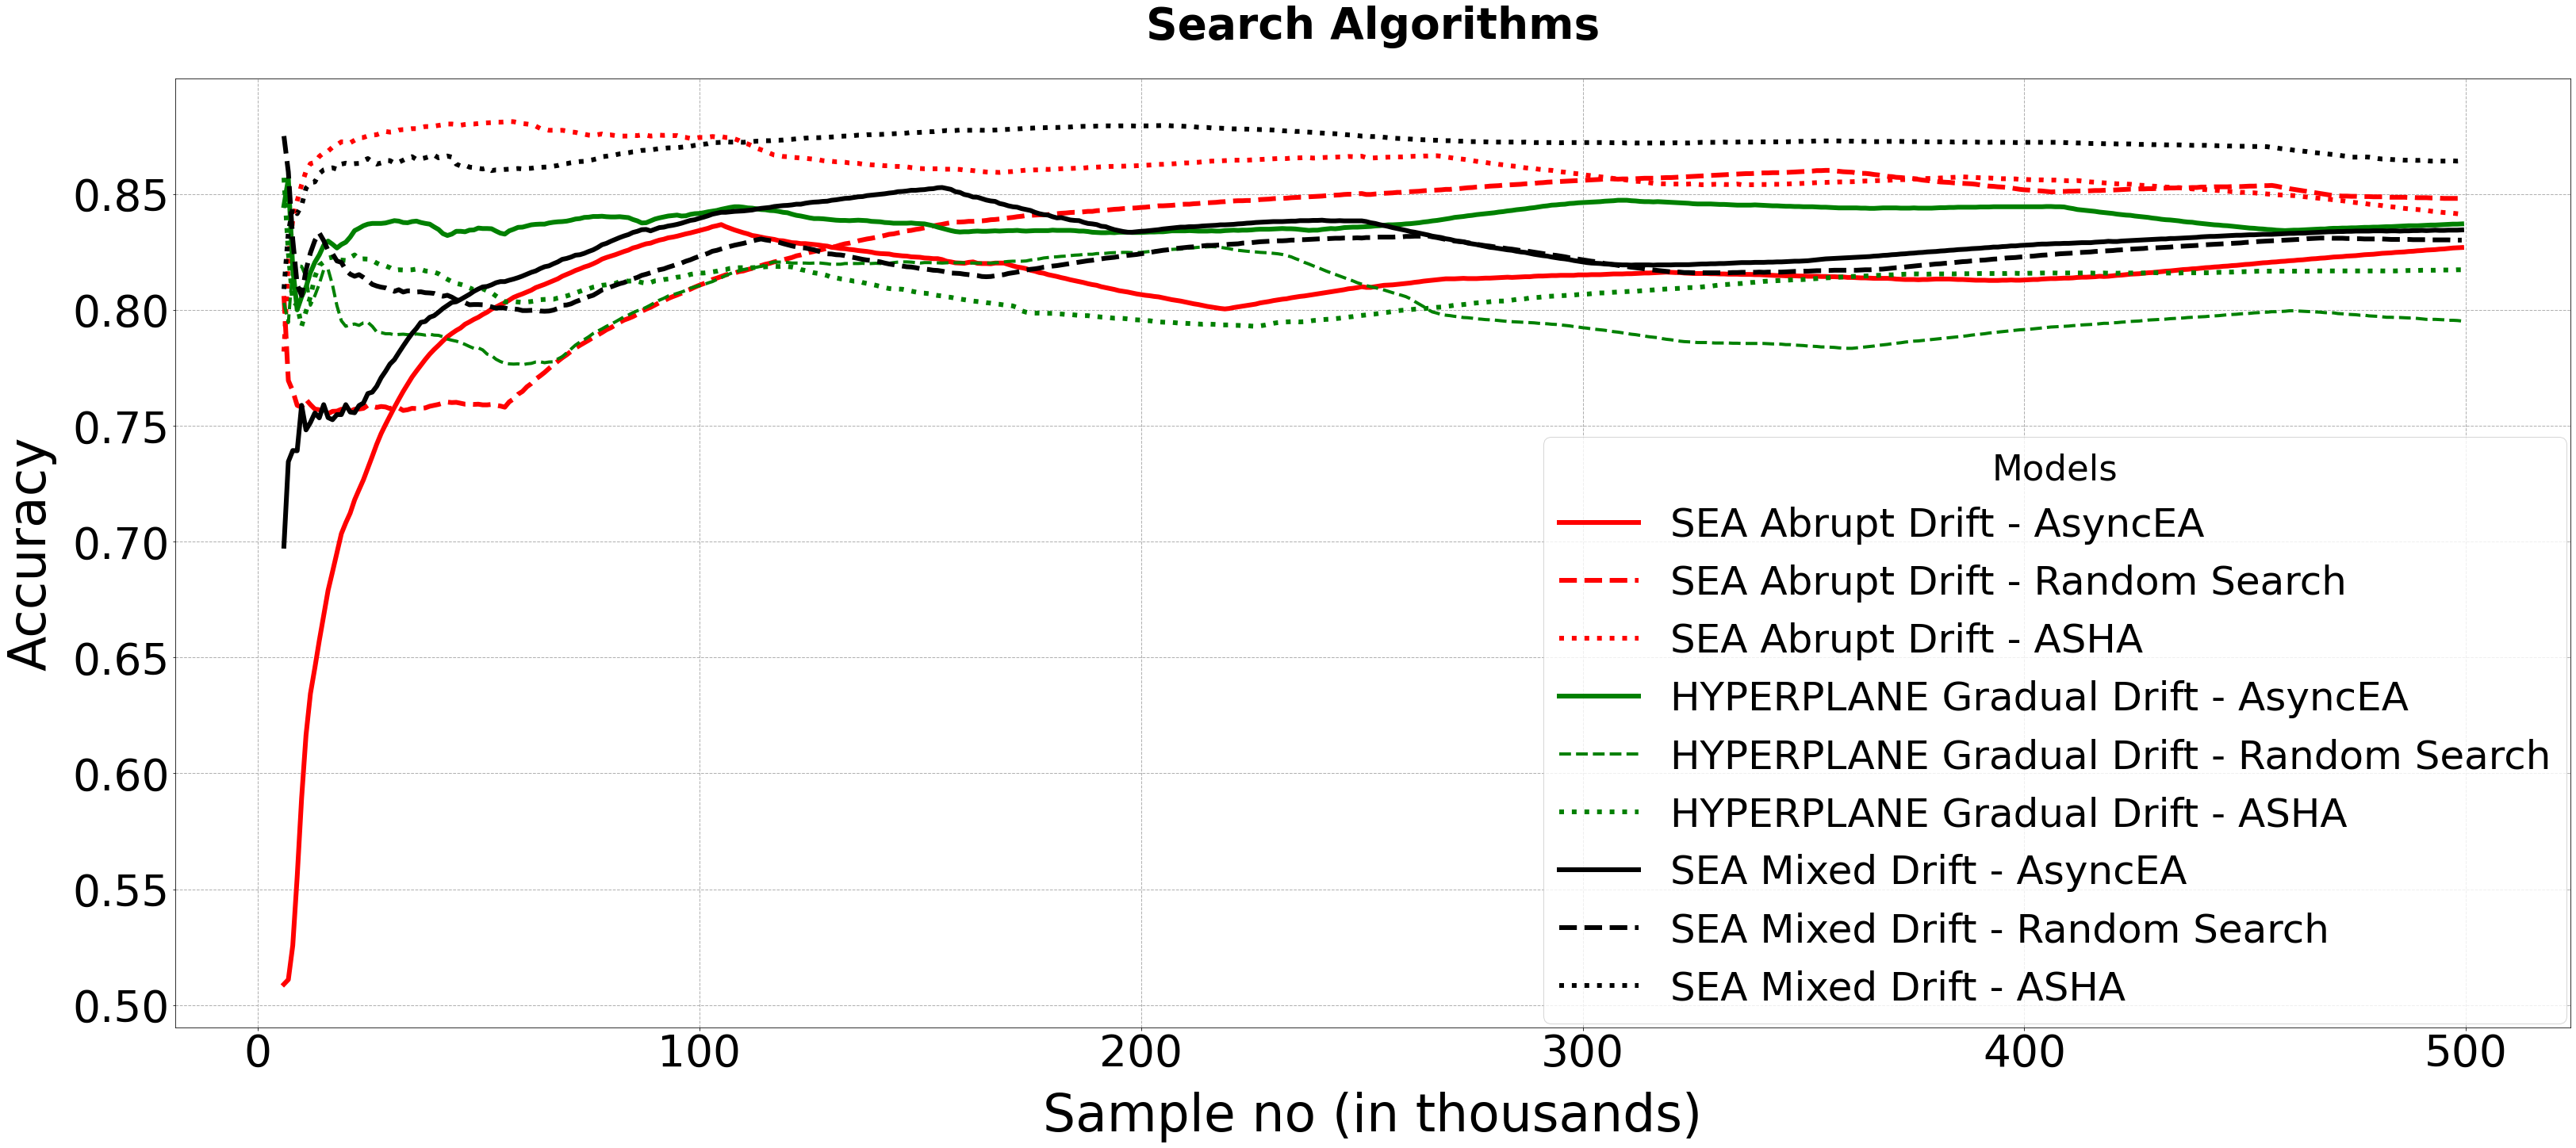

In [25]:
#Plot-2 Search Algorithms
import matplotlib
import math

figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

# data_names = ["Vehicle", "SEA - High Abrupt Drift", "HYPERPLANE - High Gradual Drift",
#               "SEA - High Mixed Drift"]
data_names = ["Catalyst Activation", "Sulfur",  "Debutaniser"]

plt.rc('font', size=45)          # controls default text sizes
plt.rc('axes', titlesize=45, titleweight = 'bold')     # fontsize of the axes title
plt.rc('axes', labelsize=45)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=55)    # fontsize of the tick labels
plt.rc('ytick', labelsize=55)    # fontsize of the tick labels
plt.rc('legend', fontsize=45)    # legend fontsize
plt.rc('figure', titlesize=40, titleweight = 'bold')  # fontsize of the figure title


plt.rcParams["figure.figsize"] = (45,20)  
plt.rcParams["axes.labelsize"] = ('x-large')
fig=plt.figure()
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', constrained_layout=True)

ax.set_title('Search Algorithms', fontsize=55, pad=50)
ax.set_xlabel("Sample no (in thousands)", labelpad=20)
ax.set_ylabel("Accuracy", labelpad=20)

ax.grid(linestyle='--', linewidth=1)
ax.set_facecolor("white")



#Plot performance lines of each version
# #Vehicle
# # evolutionary algorithm
# l0 = ax.plot(results["AutOL_Data_3" ]['basic']['Batch number'],
#                 results["AutOL_Data_3"]['basic']['Test score'],
#                 label='Vehicle - AsyncEA', lw=4, color='b')
# #random search
# l1 = ax.plot(results["AutOL_Data_3"]['randomsearch']['Batch number'],
#                 results["AutOL_Data_3"]['randomsearch']['Test score'],
#                 label='Vehicle - Random Search', lw=4, color='b', linestyle='--')
# #asha
# l2 = ax.plot(results["AutOL_Data_3"]['asha']['Batch number'],
#                 results["AutOL_Data_3"]['asha']['Test score'],
#                 label='Vehicle - ASHA', lw=4, color='b', linestyle=':')

#SEA - Abrupt
# evolutionary algorithm
l3 = ax.plot(results["AutOL_Data_4" ]['basic']['Batch number']/1000,
                results["AutOL_Data_4"]['basic']['Test score'],
                label='SEA Abrupt Drift - AsyncEA', lw=6, color='r')
#random search
l4 = ax.plot(results["AutOL_Data_4"]['randomsearch']['Batch number']/1000,
                results["AutOL_Data_4"]['randomsearch']['Test score'],
                label='SEA Abrupt Drift - Random Search', lw=6, color='r', linestyle='--')
#asha
l5 = ax.plot(results["AutOL_Data_4"]['asha']['Batch number']/1000,
                results["AutOL_Data_4"]['asha']['Test score'],
                label='SEA Abrupt Drift - ASHA', lw=6, color='r', linestyle=':')

#HYPERPLANE - Gradual
# evolutionary algorithm
l6 = ax.plot(results["AutOL_Data_5" ]['basic']['Batch number']/1000,
                results["AutOL_Data_5"]['basic']['Test score'],
                label='HYPERPLANE Gradual Drift - AsyncEA', lw=6, color='g')
#random search
l7 = ax.plot(results["AutOL_Data_5"]['randomsearch']['Batch number']/1000,
                results["AutOL_Data_5"]['randomsearch']['Test score'],
                label='HYPERPLANE Gradual Drift - Random Search', lw=4, color='g', linestyle='--')
#asha
l8 = ax.plot(results["AutOL_Data_5"]['asha']['Batch number']/1000,
                results["AutOL_Data_5"]['asha']['Test score'],
                label='HYPERPLANE Gradual Drift - ASHA', lw=6, color='g', linestyle=':')

#SEA - Mixed
# evolutionary algorithm
l9 = ax.plot(results["AutOL_Data_6" ]['basic']['Batch number']/1000,
                results["AutOL_Data_6"]['basic']['Test score'],
                label='SEA Mixed Drift - AsyncEA', lw=6, color='black')
#random search
l10 = ax.plot(results["AutOL_Data_6"]['randomsearch']['Batch number']/1000,
                results["AutOL_Data_6"]['randomsearch']['Test score'],
                label='SEA Mixed Drift - Random Search', lw=6, color='black', linestyle='--')
#asha
l11 = ax.plot(results["AutOL_Data_6"]['asha']['Batch number']/1000,
                results["AutOL_Data_6"]['asha']['Test score'],
                label='SEA Mixed Drift - ASHA', lw=6, color='black', linestyle=':')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels,
           loc='lower right',
           #bbox_to_anchor=(0.5, -0.12),
           ncol=1,
           borderaxespad=0.1,
           title="Models",
           prop={'size': 50})

#plt.yticks(np.arange(results["AutOL_Ensemble_Data_" + str(d)]['Test score'], results["AutOL_Ensemble_Data_" + str(d)]['Test score']+0.1, 0.1))

plt.plot()
fig.show()
fig.savefig(link_to_files+"/Search_algorithms.png")


KeyError: 'AutOL_Data_5'

<Figure size 1800x2160 with 0 Axes>

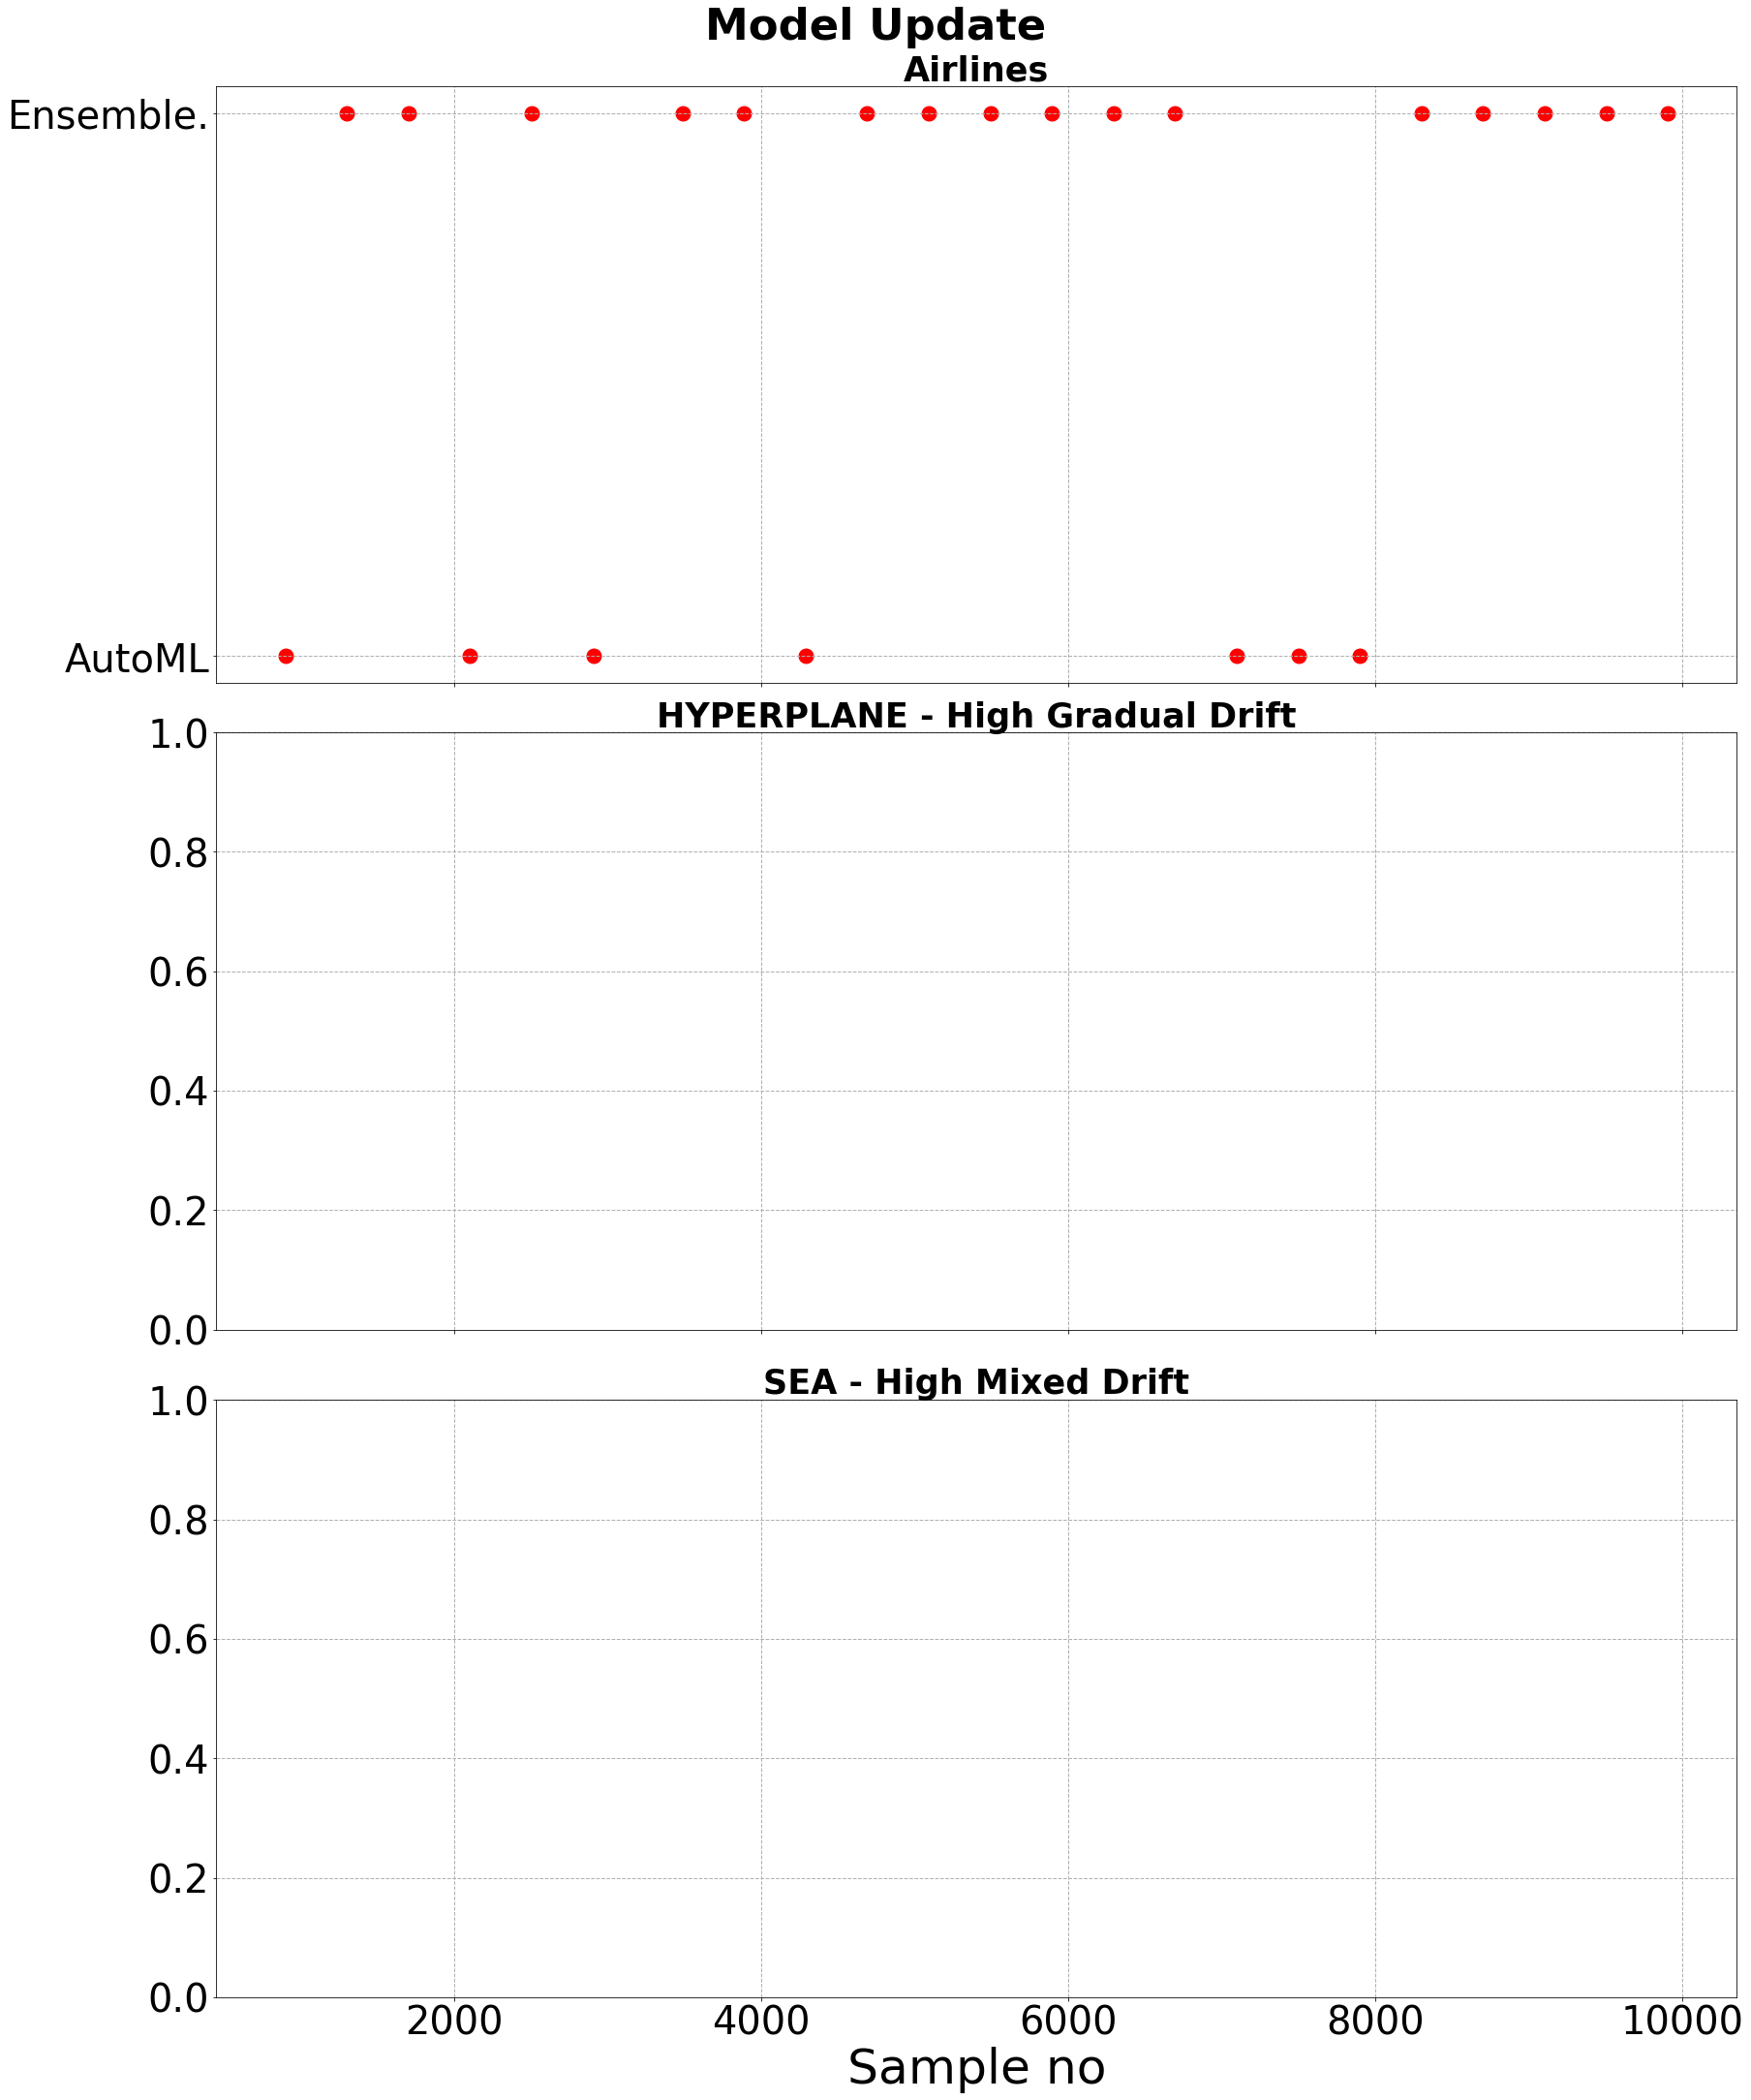

In [4]:
#Plot-3 Model Update
import matplotlib
import math

figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35


plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold')     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=40, titleweight = 'bold')  # fontsize of the figure title


plt.rcParams["figure.figsize"] = (25,30)
plt.rcParams["axes.labelsize"] = ('x-large')

fig=plt.figure()
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row',constrained_layout=True)
fig.suptitle('Model Update', fontsize=45)

for i in range(0,3):
    ax[i].grid(linestyle='--', linewidth=1)
    ax[i].set_facecolor("white")
ax[2].set(xlabel="Sample no")

ax[0].set_title('Airlines')
ax[1].set_title('HYPERPLANE - High Gradual Drift')
ax[2].set_title('SEA - High Mixed Drift')


#Airlines
#ensemble
l1 = ax[0].scatter(retrainings["AutOL_Data_1"]["ensemble"]['Batch number'],
             retrainings["AutOL_Data_1"]["ensemble"]['Model update'],
                label='OAML - Ensemble', lw=10, color='r')
# #model store
# l2 = ax[0].scatter(retrainings["AutOL_Data_1"]["modelstore"]['Batch number'],
#                 retrainings["AutOL_Data_1"]["modelstore"]['Model update'],
#                 label='OAML - Model Store', lw=10, color='g')
        

#High Gradual
#ensemble
l1 = ax[1].plot(retrainings["AutOL_Data_5"]["ensemble"]['Batch number'],
             retrainings["AutOL_Data_5"]["ensemble"]['Model update'],
                label='OAML - Ensemble', lw=4, color='r')
#model store
l2 = ax[1].plot(retrainings["AutOL_Data_5"]["modelstore"]['Batch number'],
             retrainings["AutOL_Data_5"]["modelstore"]['Model update'],
                label='OAML - Model Store', lw=4, color='g')
        

#High Mixed
#ensemble
l1 = ax[2].plot(retrainings["AutOL_Data_6"]["ensemble"]['Batch number'],
             retrainings["AutOL_Data_6"]["ensemble"]['Model update'],
                label='OAML - Ensemble', lw=4, color='r')
#model store
l2 = ax[2].plot(retrainings["AutOL_Data_6"]["modelstore"]['Batch number'],
             retrainings["AutOL_Data_6"]["modelstore"]['Model update'],
                label='OAML - Model Store', lw=4, color='g')


handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.65),
           ncol=1,
           borderaxespad=0.1,
           title="Models",
           prop={'size': 45})


plt.plot()
fig.show()
fig.savefig(link_to_files+"/ModelUpdate.png")
    

In [5]:
results["AutOL_Data_0" ]['ensemble']['Batch number']

0        0
1      522
2      580
3      638
4      696
      ... 
89    5626
90    5684
91    5742
92    5800
93    5858
Name: Batch number, Length: 94, dtype: int64

In [9]:
retrainings["AutOL_Data_0"]["ensemble"]['Batch number']

0    1603
1    3132
2    5522
Name: Batch number, dtype: int64

/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_1275/3843567370.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[0].plot(x_ensemble[start:-1], y_ensemble[start:-1], lw=5)


[]

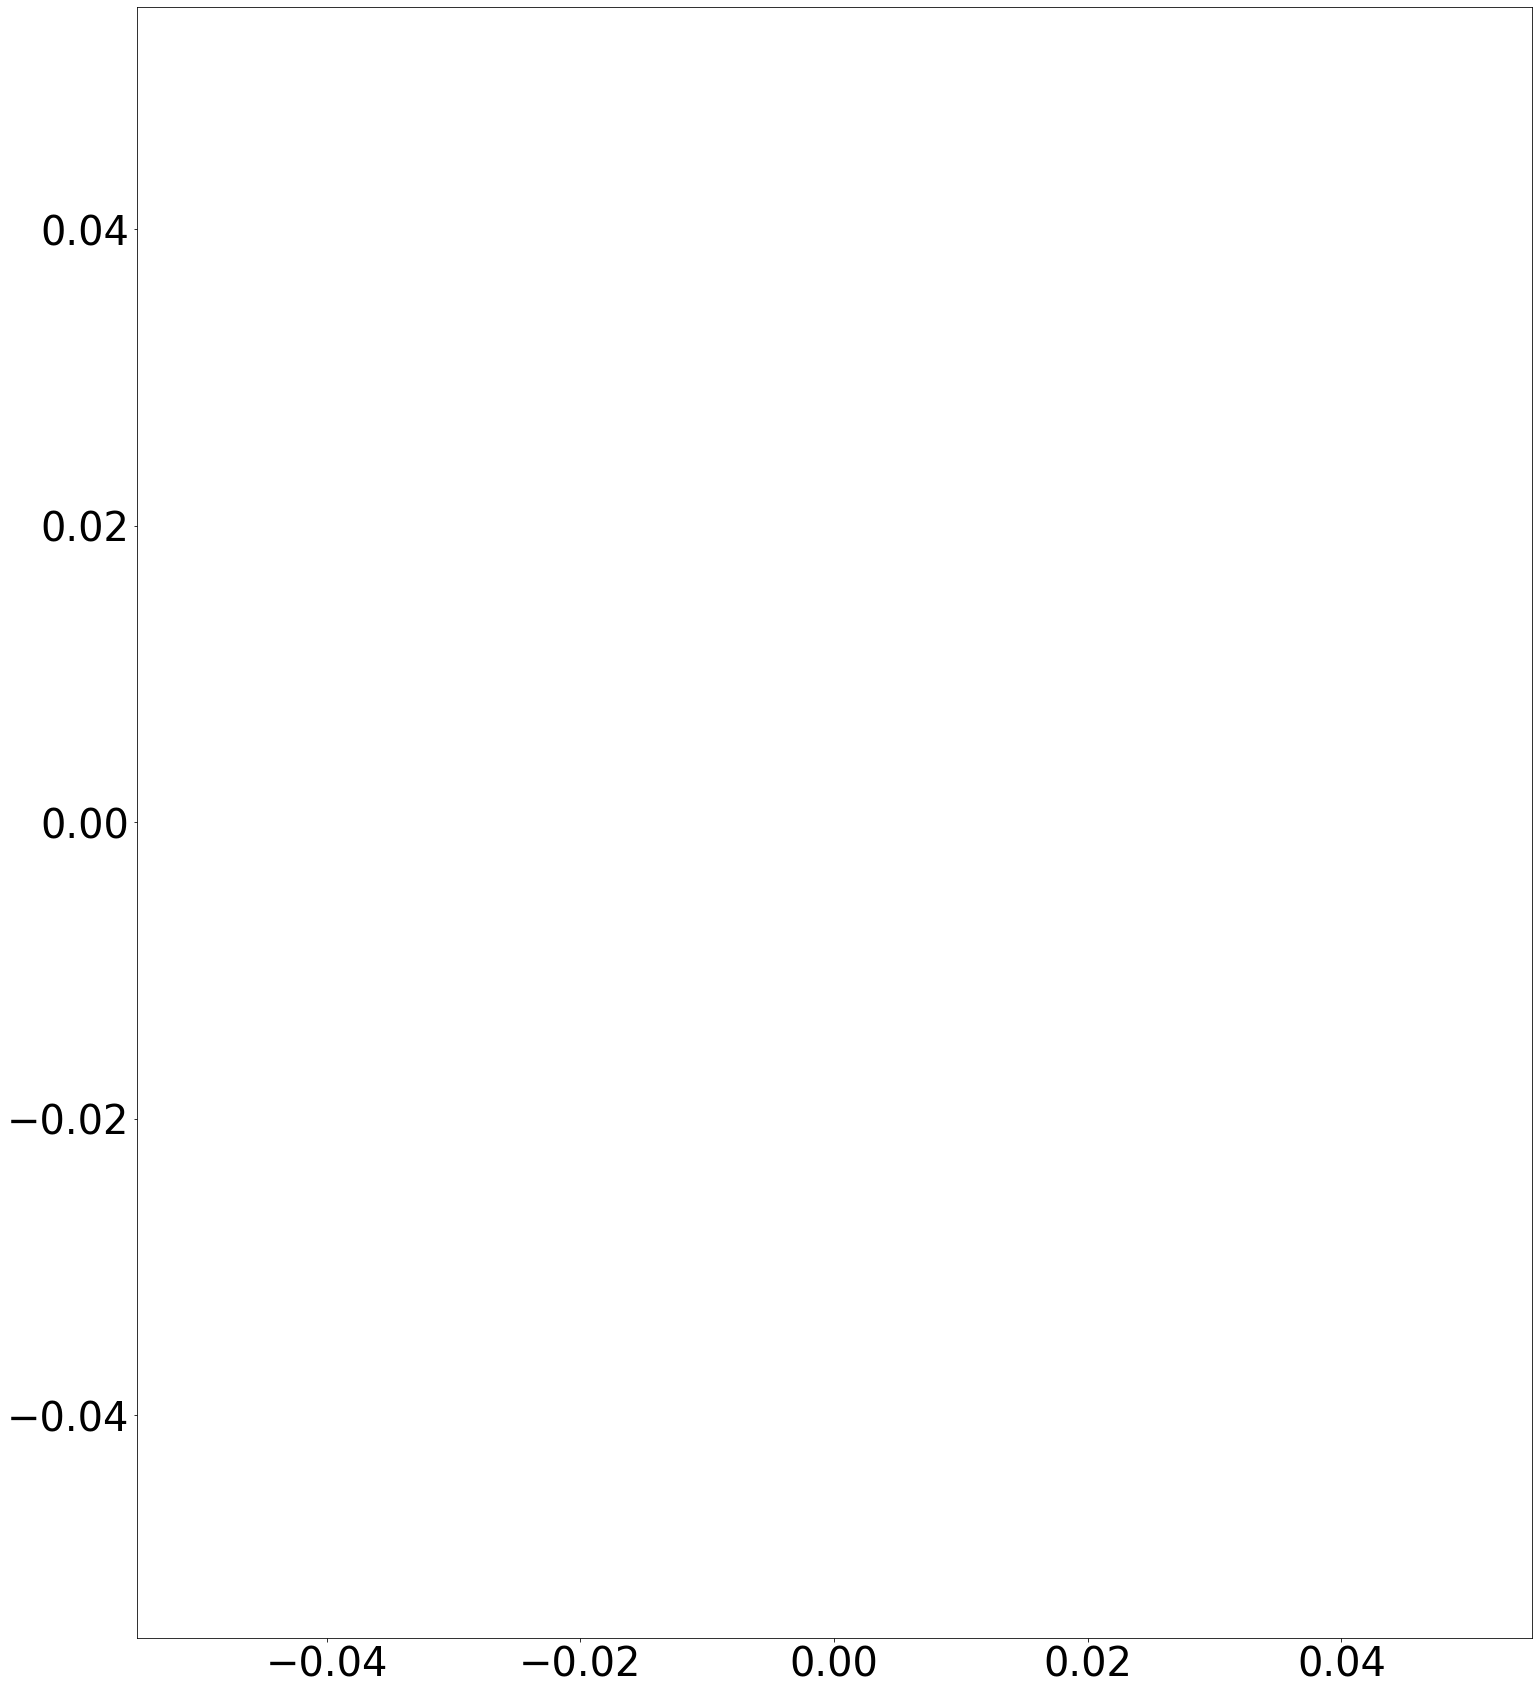

In [14]:
colors_ensemble= ['orange' if a=='Ensemble.' else 'g' for a in retrainings["AutOL_Data_0"]["ensemble"]['Model update']]
x_ensemble = results["AutOL_Data_0" ]['ensemble']['Batch number']
y_ensemble = results["AutOL_Data_0" ]['ensemble']['Test score']

start=1
for i in range(1,len(colors_ensemble)-1):
    for j in range(start, retrainings["AutOL_Data_0"]["ensemble"]['Batch number'][i], 20):
        continue
    end=int(j/20 - 6)
    ax[0].plot(x_ensemble[start:end+1], y_ensemble[start:end+1], color=colors_ensemble[i], lw=5)
    start = end
ax[0].plot(x_ensemble[start:-1], y_ensemble[start:-1], lw=5)
ax[0].set_label('OAML - Model Store') 
plt.plot()
# fig.show()


In [141]:
#Plot-3 Model Update alternative - with performance
import matplotlib
import math
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects

figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35


plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold')     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=40, titleweight = 'bold')  # fontsize of the figure title


plt.rcParams["figure.figsize"] = (25,35)
plt.rcParams["axes.labelsize"] = ('x-large')

fig=plt.figure()
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row',constrained_layout=True)
fig.suptitle('Model Update', fontsize=45)



#Airlines
#model store
# colors_modelstore = ['r' if a=='Store' else 'g' for a in retrainings["AutOL_Data_1"]["modelstore"]['Model update']]
# x_modelstore = results["AutOL_Data_1" ]['modelstore']['Batch number']
# y_modelstore = results["AutOL_Data_1" ]['modelstore']['Test score']

# start=1
# lines_modelstore=[]
# for i in range(1,len(colors_modelstore)):
#     for j in range(start, retrainings["AutOL_Data_1"]["modelstore"]['Batch number'][i], 1000):
#         continue
#     end=int(j/1000 - 6)
#     ax[0].plot(x_modelstore[start:end+1], y_modelstore[start:end+1], color=colors_modelstore[i], lw=5)
#     start = end
# ax[0].plot(x_modelstore[start:-1], y_modelstore[start:-1], color=colors_modelstore[i-1], lw=5)
# ax[0].set_label('OAML - Model Store') 

# #ensemble
colors_ensemble= ['orange' if a=='Ensemble.' else 'g' for a in retrainings["AutOL_Data_0"]["ensemble"]['Model update']]
x_ensemble = results["AutOL_Data_0" ]['ensemble']['Batch number']
y_ensemble = results["AutOL_Data_0" ]['ensemble']['Test score']

start=1
for i in range(1,len(colors_ensemble)-1):
    for j in range(start, retrainings["AutOL_Data_0"]["ensemble"]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    ax[0].plot(x_ensemble[start:end+1], y_ensemble[start:end+1], color=colors_ensemble[i], lw=5)
    start = end
ax[0].plot(x_ensemble[start:-1], y_ensemble[start:-1], color=colors_ensemble[i], lw=5)
ax[0].set_label('OAML - Model Store') 



# # #High Gradual
#model store
# colors_modelstore = ['r' if a=='Store' else 'g' for a in retrainings["AutOL_Data_5"]["modelstore"]['Model update']]
# x_modelstore = results["AutOL_Data_5" ]['modelstore']['Batch number']
# y_modelstore = results["AutOL_Data_5" ]['modelstore']['Test score']

# start=1
# lines_modelstore=[]
# for i in range(1,len(colors_modelstore)):
#     for j in range(start, retrainings["AutOL_Data_5"]["modelstore"]['Batch number'][i], 1000):
#         continue
#     end=int(j/1000 - 6)
#     ax[1].plot(x_modelstore[start:end+1], y_modelstore[start:end+1], color=colors_modelstore[i], lw=5)
#     start = end
# ax[1].plot(x_modelstore[start:-1], y_modelstore[start:-1], color=colors_modelstore[i-1], lw=5)
# ax[1].set_label('OAML - Model Store') 

# #ensemble
colors_ensemble= ['orange' if a=='Ensemble.' else 'g' for a in retrainings["AutOL_Data_1"]["ensemble"]['Model update']]
x_ensemble = results["AutOL_Data_1" ]['ensemble']['Batch number']
y_ensemble = results["AutOL_Data_1" ]['ensemble']['Test score']

start=1
lines_ensemble=[]
for i in range(1,len(colors_ensemble)):
    for j in range(start, retrainings["AutOL_Data_1"]["ensemble"]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    ax[1].plot(x_ensemble[start:end+1], y_ensemble[start:end+1], color=colors_ensemble[i], lw=5)
    start = end
ax[1].plot(x_ensemble[start:-1], y_ensemble[start:-1], color=colors_ensemble[i-1], lw=5)
ax[1].set_label('OAML - Model Store')       


#High Mixed
#model store
# colors_modelstore = ['r' if a=='Store' else 'g' for a in retrainings["AutOL_Data_6"]["modelstore"]['Model update']]
# x_modelstore = results["AutOL_Data_6" ]['modelstore']['Batch number']
# y_modelstore = results["AutOL_Data_6" ]['modelstore']['Test score']

# start=1
# lines_modelstore=[]
# for i in range(1,len(colors_modelstore)):
#     for j in range(start, retrainings["AutOL_Data_6"]["modelstore"]['Batch number'][i], 1000):
#         continue
#     end=int(j/1000 - 6)
#     ax[2].plot(x_modelstore[start:end+1], y_modelstore[start:end+1], color=colors_modelstore[i], lw=5)
#     start = end
# ax[2].plot(x_modelstore[start:-1], y_modelstore[start:-1], color=colors_modelstore[i-1], lw=5)
# ax[2].set_label('OAML - Model Store') 

# #ensemble
colors_ensemble= ['orange' if a=='Ensemble.' else 'g' for a in retrainings["AutOL_Data_2"]["ensemble"]['Model update']]
x_ensemble = results["AutOL_Data_2" ]['ensemble']['Batch number']
y_ensemble = results["AutOL_Data_2" ]['ensemble']['Test score']

start=1
lines_ensemble=[]
for i in range(0,len(colors_ensemble)):
    for j in range(start, retrainings["AutOL_Data_2"]["ensemble"]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    ax[2].plot(x_ensemble[start:end+1], y_ensemble[start:end+1], color=colors_ensemble[i], lw=5)
    start = end

ax[2].plot(x_ensemble[start:-1], y_ensemble[start:-1], color=colors_ensemble[i-1], lw=5)
ax[2].set_label('OAML - Model Store') 


for i in range(0,3):
    ax[i].grid(linestyle='--', linewidth=1)
    ax[i].set_facecolor("white")
    ax[i].autoscale()
    ax[i].set_ylabel("Accuracy", labelpad=20)
ax[2].set_xlabel("Sample no (in thousands)", labelpad=20)
ax[2].set_xticklabels(range(-100,600,100))

ax[0].set_title('Airlines', pad=30)
ax[1].set_title('HYPERPLANE - High Gradual Drift', pad=30)
ax[2].set_title('SEA - High Mixed Drift', pad=30)


ax[0].text(435000, 0.63, 'OAML - Model Store')
ax[0].text(435000, 0.675, 'OAML - Ensemble')

ax[1].text(0, 0.86, 'OAML - Model Store')
ax[1].text(120000, 0.82, 'OAML - Ensemble')

ax[2].text(435000, 0.89, 'OAML - Ensemble')
ax[2].text(435000, 0.86, 'OAML - Model Store')


legend_elements = [Line2D([0], [0], color='red', lw=10, label='Model Store'),
                   Line2D([0], [0], color='orange', lw=10, label='Ensemble'),
                   Line2D([0], [0], color='green', lw=10, label='AutoML Model')]

ax[2].legend(handles=legend_elements, 
           loc='lower center',
           bbox_to_anchor=(0.5, -0.7),
           ncol=1,
           borderaxespad=0.1,
           title="Models",
           prop={'size': 45})
            

plt.plot()
fig.show()
fig.savefig(link_to_files+"/ModelUpdate.png")
    

/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_9363/49987021.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(range(-100,600,100))
/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_9363/49987021.py:173: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/vq/1fmh90md2sbgsnlm5q1k_k9r0000gn/T/ipykernel_9363/49987021.py:174: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(link_to_files+"/ModelUpdate.png")


<Figure size 1800x2520 with 0 Axes>

/Users/lota/opt/anaconda3/envs/default-oaml/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


/Users/bcelik/opt/anaconda3/envs/gama_env/lib/python3.7/site-packages/ipykernel_launcher.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/bcelik/opt/anaconda3/envs/gama_env/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 2520x3240 with 0 Axes>

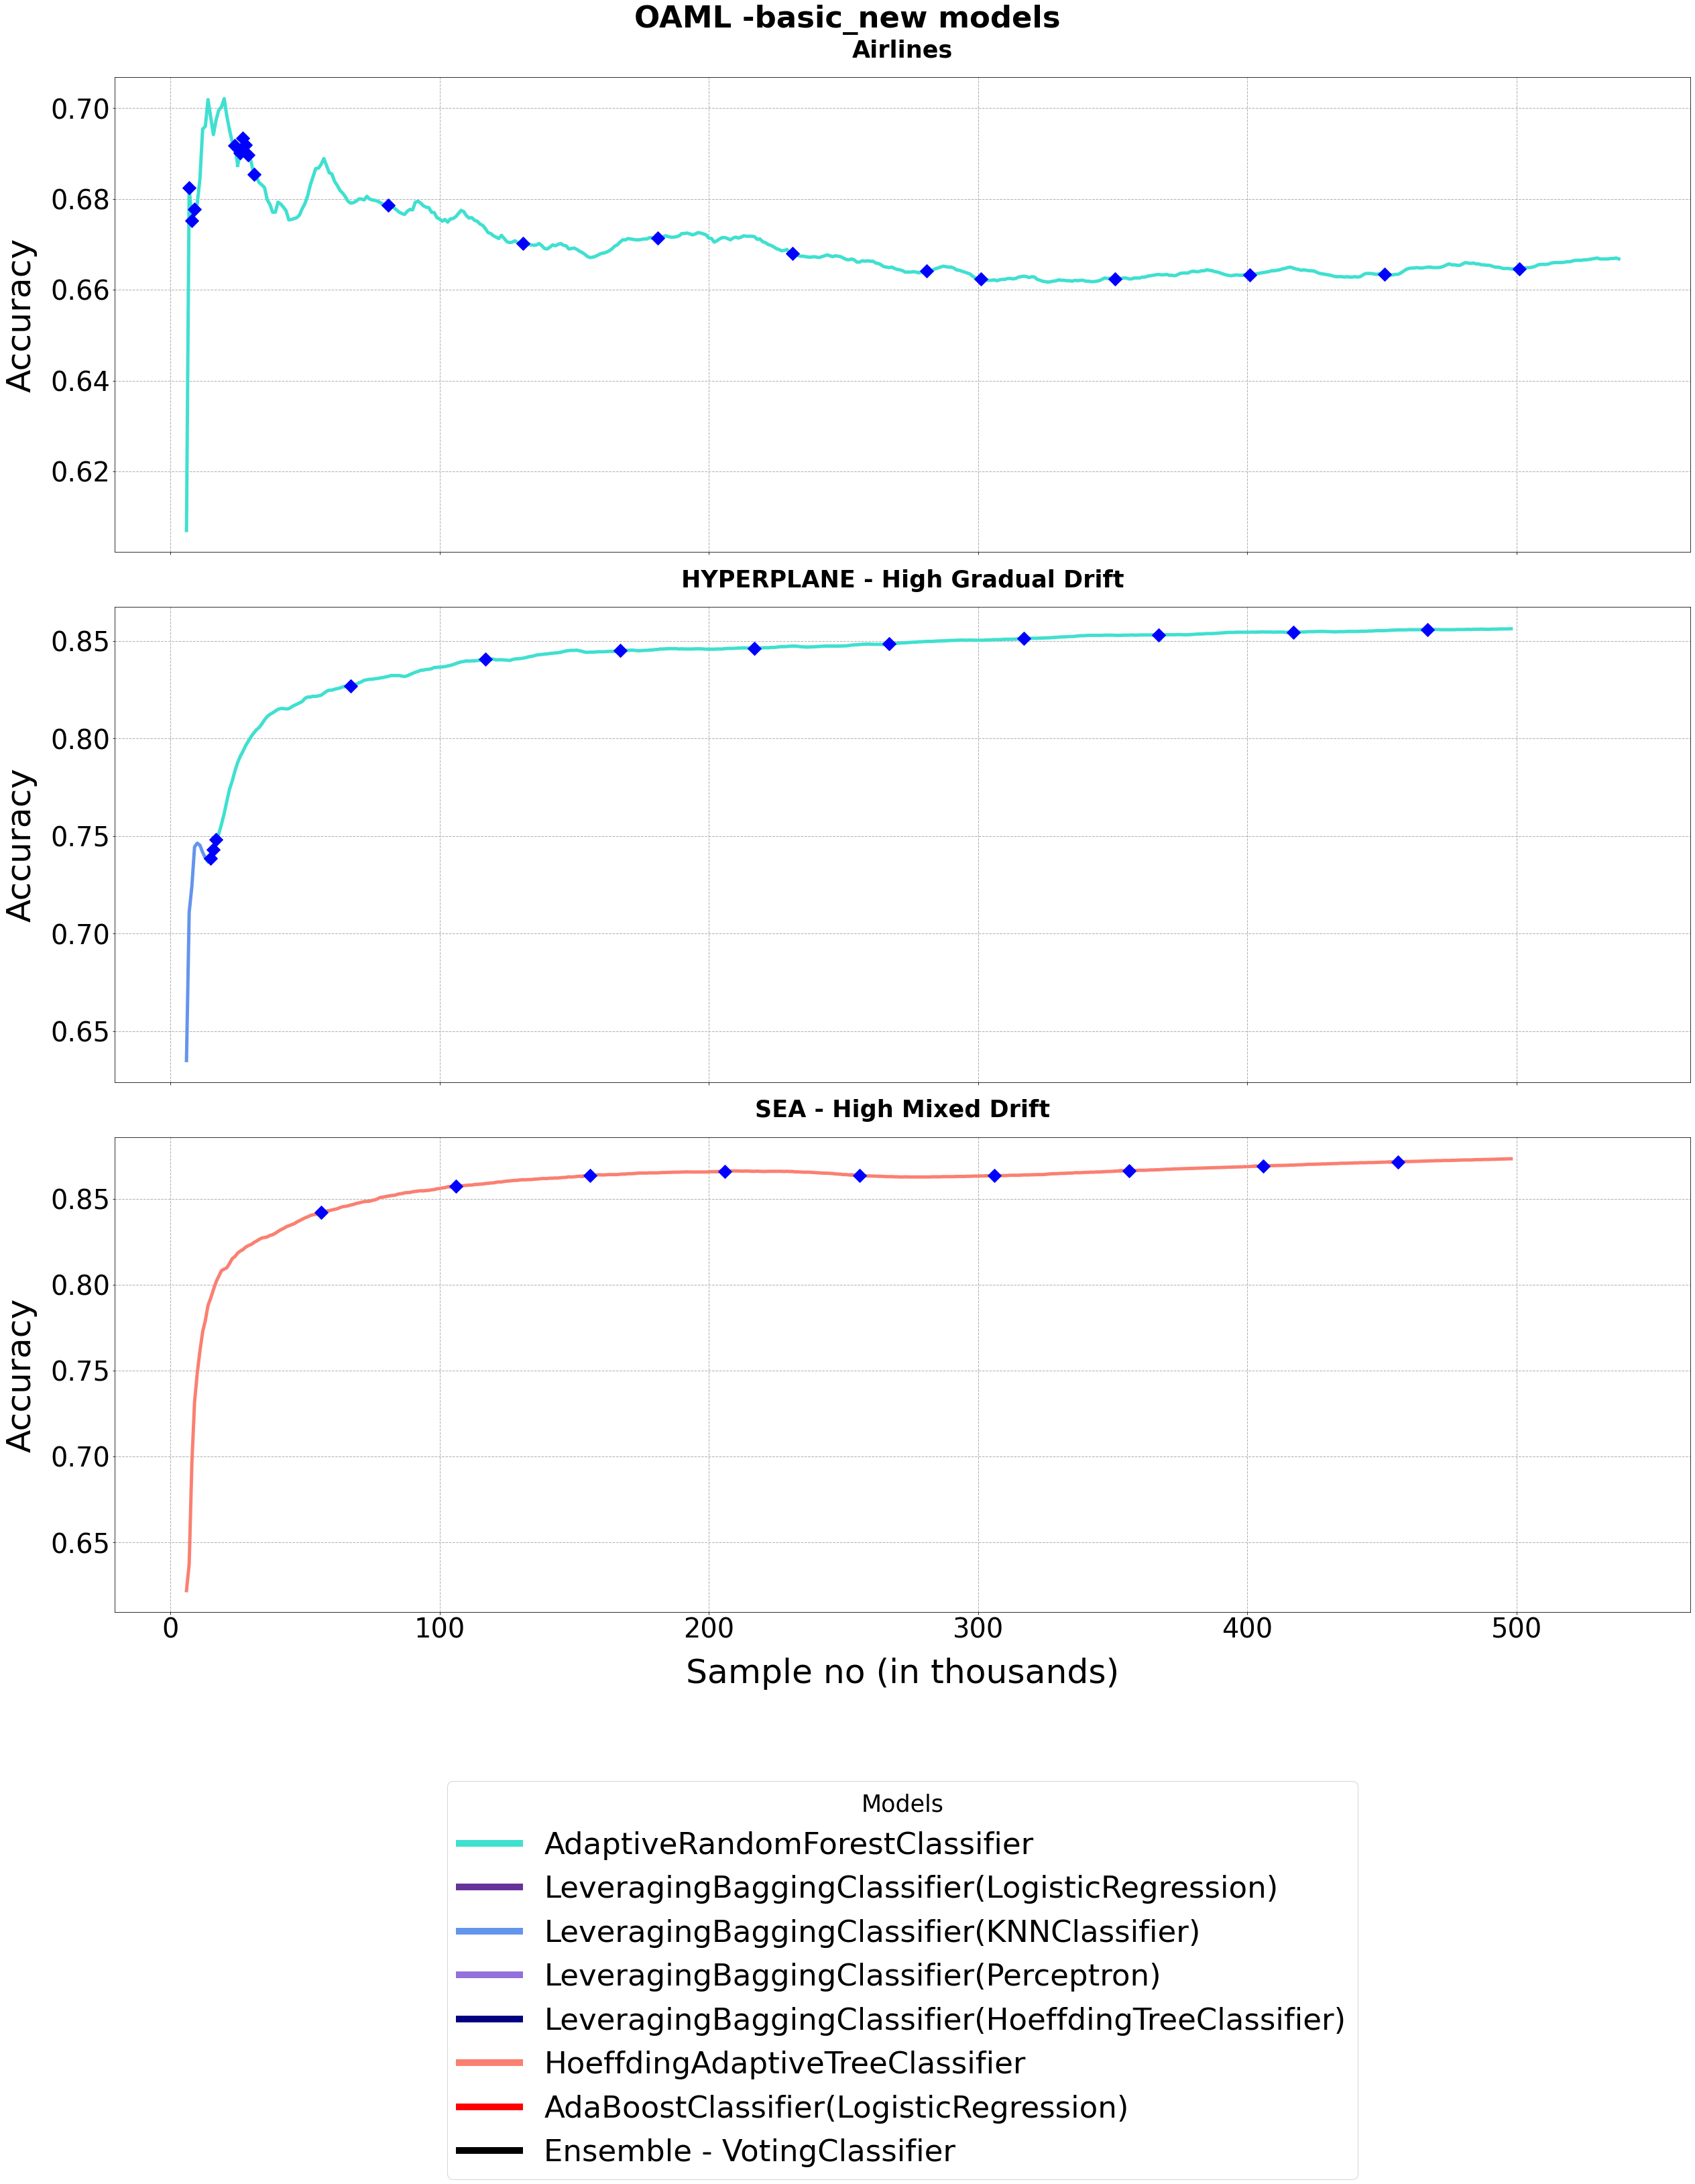

In [9]:
#Plot-4 Models alternative - with performance
import matplotlib
import math
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects

figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

version = 'basic_new'

def make_marker_array(a,e,choice):
    b= a[choice]
    c = list(b['Batch number'])
    r = []
    for j in c:
        i = math.ceil(j/1000)*1000
        r.append(i)
    both = set(r).intersection(e)
    e=list(e)
    markon = [e.index(x) for x in both]
    return markon

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold')     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=40, titleweight = 'bold')  # fontsize of the figure title


plt.rcParams["figure.figsize"] = (35,45)
plt.rcParams["axes.labelsize"] = ('x-large')

fig=plt.figure()
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row',constrained_layout=True)
fig.suptitle('OAML -'+version+' models', fontsize=45)



#Airlines
colors_models = ['turquoise' if a=='AdaptiveRandomForestClassifier' 
                     else 'rebeccapurple' if a=='LeveragingBaggingClassifier(LogisticRegression)'
                     else 'cornflowerblue' if a=='LeveragingBaggingClassifier(KNNClassifier)'
                     else 'mediumpurple' if a=='LeveragingBaggingClassifier(Perceptron)'
                     else 'navy' if a=='LeveragingBaggingClassifier(HoeffdingTreeClassifier)'
                     else 'salmon' if a=='HoeffdingAdaptiveTreeClassifier'
                     else 'black' if a=='VotingClassifier'
                     else 'red' if a=='AdaBoostClassifier(LogisticRegression)'
                     else 'yellow'
                     for a in models["AutOL_Data_1"][version]['model']]

x_model = results["AutOL_Data_1" ][version]['Batch number']
y_model = results["AutOL_Data_1" ][version]['Test score']

start=1
for i in range(1,len(colors_models)-1):
    for j in range(start, retrainings["AutOL_Data_1"][version]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    ax[0].plot(x_model[start:end+1], y_model[start:end+1], color=colors_models[i], lw=5)
    start = end
ax[0].plot(x_model[start:-1], y_model[start:-1], color=colors_models[i], lw=5)


#High Gradual
colors_models = ['turquoise' if a=='AdaptiveRandomForestClassifier' 
                     else 'rebeccapurple' if a=='LeveragingBaggingClassifier(LogisticRegression)'
                     else 'cornflowerblue' if a=='LeveragingBaggingClassifier(KNNClassifier)'
                     else 'mediumpurple' if a=='LeveragingBaggingClassifier(Perceptron)'
                     else 'navy' if a=='LeveragingBaggingClassifier(HoeffdingTreeClassifier)'
                     else 'salmon' if a=='HoeffdingAdaptiveTreeClassifier'
                     else 'black' if a=='VotingClassifier'
                     else 'red' if a=='AdaBoostClassifier(LogisticRegression)'
                     else 'yellow'
                     for a in models["AutOL_Data_5"][version]['model']]

x_model = results["AutOL_Data_5" ][version]['Batch number']
y_model = results["AutOL_Data_5" ][version]['Test score']

start=1
for i in range(1,len(colors_models)-1):
    for j in range(start, retrainings["AutOL_Data_5"][version]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    ax[1].plot(x_model[start:end+1], y_model[start:end+1], color=colors_models[i], lw=5)
    start = end
ax[1].plot(x_model[start:-1], y_model[start:-1], color=colors_models[i], lw=5)     


#High Mixed
colors_models = ['turquoise' if a=='AdaptiveRandomForestClassifier' 
                     else 'rebeccapurple' if a=='LeveragingBaggingClassifier(LogisticRegression)'
                     else 'cornflowerblue' if a=='LeveragingBaggingClassifier(KNNClassifier)'
                     else 'mediumpurple' if a=='LeveragingBaggingClassifier(Perceptron)'
                     else 'navy' if a=='LeveragingBaggingClassifier(HoeffdingTreeClassifier)'
                     else 'salmon' if a=='HoeffdingAdaptiveTreeClassifier'
                     else 'black' if a=='VotingClassifier'
                     else 'red' if a=='AdaBoostClassifier(LogisticRegression)'
                     else 'yellow'
                     for a in models["AutOL_Data_6"][version]['model']]

#Plot segments of performance plots
x_model = results["AutOL_Data_6" ][version]['Batch number']
y_model = results["AutOL_Data_6" ][version]['Test score']

start=1
for i in range(1,len(colors_models)-1):
    for j in range(start, retrainings["AutOL_Data_6"][version]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    ax[2].plot(x_model[start:end+1], y_model[start:end+1], color=colors_models[i], lw=5)
    start = end
ax[2].plot(x_model[start:-1], y_model[start:-1], color=colors_models[i], lw=5)

#mark retrainings

#Mark Airlines
a = retrainings['AutOL_Data_1']
e = results["AutOL_Data_1"][version]['Batch number']
markonb = make_marker_array(a,e,version)
markonb = [x-1 for x in markonb]


ax[0].plot(results["AutOL_Data_1"][version]['Batch number'][1:-1],
                results["AutOL_Data_1"][version]['Test score'][1:-1],
                ms = 14, marker='D', markeredgecolor='b', markevery=markonb,
                lw=6, color='b', linestyle='None')

#Mark High Gradual
a = retrainings['AutOL_Data_5']
e = results["AutOL_Data_5"][version]['Batch number']
markonb = make_marker_array(a,e,version)
markonb = [x-1 for x in markonb]


ax[1].plot(results["AutOL_Data_5"][version]['Batch number'][1:-1],
                results["AutOL_Data_5"][version]['Test score'][1:-1],
                ms = 14, marker='D', markeredgecolor='b', markevery=markonb,
                lw=6, color='b', linestyle='None')


#Mark High Mixed
a = retrainings['AutOL_Data_6']
e = results["AutOL_Data_6"][version]['Batch number']
markonb = make_marker_array(a,e,version)
markonb = [x-1 for x in markonb]


ax[2].plot(results["AutOL_Data_6"][version]['Batch number'][1:-1],
                results["AutOL_Data_6"][version]['Test score'][1:-1],
                ms = 14, marker='D', markeredgecolor='b', markevery=markonb,
                lw=6, color='b', linestyle='None')


#Style
for i in range(0,3):
    ax[i].grid(linestyle='--', linewidth=1)
    ax[i].set_facecolor("white")
    ax[i].autoscale()
    ax[i].set_ylabel("Accuracy", labelpad=20)

ax[2].set_xlabel("Sample no (in thousands)", labelpad=20)
ax[2].set_xticklabels(range(-100,600,100))

ax[0].set_title('Airlines', pad=30)
ax[1].set_title('HYPERPLANE - High Gradual Drift', pad=30)
ax[2].set_title('SEA - High Mixed Drift', pad=30)



legend_elements = [Line2D([0], [0], color='turquoise', lw=10, label='AdaptiveRandomForestClassifier'),
                   Line2D([0], [0], color='rebeccapurple', lw=10, label='LeveragingBaggingClassifier(LogisticRegression)'),
                   Line2D([0], [0], color='cornflowerblue', lw=10, label='LeveragingBaggingClassifier(KNNClassifier)'),
                   Line2D([0], [0], color='mediumpurple', lw=10, label='LeveragingBaggingClassifier(Perceptron)'),
                   Line2D([0], [0], color='navy', lw=10, label='LeveragingBaggingClassifier(HoeffdingTreeClassifier)'),
                   Line2D([0], [0], color='salmon', lw=10, label='HoeffdingAdaptiveTreeClassifier'),
                   Line2D([0], [0], color='red', lw=10, label='AdaBoostClassifier(LogisticRegression)'),
                   Line2D([0], [0], color='black', lw=10, label='Ensemble - VotingClassifier')]

ax[2].legend(handles=legend_elements, 
           loc='lower center',
           bbox_to_anchor=(0.5, -1.2),
           ncol=1,
           borderaxespad=0.1,
           title="Models",
           prop={'size': 45})
            

plt.plot()
fig.show()
#fig.savefig(link_to_files+"/Models_"+version+".png") 

In [17]:
models["AutOL_Data_1"]["modelstore"]['model']

['AdaptiveRandomForestClassifier',
 'HoeffdingAdaptiveTreeClassifier',
 'LeveragingBaggingClassifier(LogisticRegression)',
 'AdaptiveRandomForestClassifier',
 'LeveragingBaggingClassifier(KNNClassifier)',
 'LeveragingBaggingClassifier(KNNClassifier)',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'LeveragingBaggingClassifier(HoeffdingTreeClassifier)',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'LeveragingBaggingClassifier(HoeffdingTreeClassifier)',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'LeveragingBaggingClassifier(KNNClassifier)',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClassifier',
 'AdaptiveRandomForestClass

In [5]:
retrainings['AutOL_Data_6']['ensemble']


Batch number Type Model update
0         55001   No    Ensemble.
1        105002   No    Ensemble.
2        155003   No    Ensemble.
3        205004   No    Ensemble.
4        255005   No    Ensemble.
5        305006   No    Ensemble.
6        355007   No    Ensemble.
7        405008   No    Ensemble.
8        455009   No    Ensemble.

In [33]:
colors_models = ['turquoise' if a=='AdaptiveRandomForestClassifier' 
                     else 'rebeccapurple' if a=='LeveragingBaggingClassifier(LogisticRegression)'
                     else 'cornflowerblue' if a=='LeveragingBaggingClassifier(KNNClassifier)'
                     else 'mediumpurple' if a=='LeveragingBaggingClassifier(Perceptron)'
                     else 'navy' if a=='LeveragingBaggingClassifier(HoeffdingTreeClassifier)'
                     else 'salmon' if a=='HoeffdingAdaptiveTreeClassifier'
                     else 'black' if a=='VotingClassifier'
                     else 'yellow'
                     for a in models["AutOL_Data_1"][version]['model']]
colors_models

['cornflowerblue',
 'black',
 'cornflowerblue',
 'turquoise',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'navy',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'turquoise',
 'turquoise',
 'black',
 'black',
 'black']

In [21]:
colors_models = ['turquoise' if a=='AdaptiveRandomForestClassifier' 
                     else 'rebeccapurple' if a=='LeveragingBaggingClassifier(LogisticRegression)'
                     else 'blueviolet' if a=='LeveragingBaggingClassifier(KNNClassifier)'
                     else 'indigo' if a=='LeveragingBaggingClassifier(Perceptron)'
                     else 'royalblue' if a=='LeveragingBaggingClassifier(HoeffdingTreeClassifier)'
                     else 'salmon' if a=='HoeffdingAdaptiveTreeClassifier'
                     else 'black' if a=='VotingClassifier'
                     else 'yellow'
                     for a in models["AutOL_Data_1"]["ensemble"]['model']]

print(models["AutOL_Data_1"]["ensemble"]['model'])
print(colors_models)

x_basic = results["AutOL_Data_1" ]['ensemble']['Batch number']
y_basic = results["AutOL_Data_1" ]['ensemble']['Test score']

start=0
lines=[]
for i in range(0,len(colors_models)-1):
    for j in range(start, retrainings["AutOL_Data_1"]["ensemble"]['Batch number'][i], 1000):
        continue
    end=int(j/1000 - 6)
    print('start is {} and end is {} with color {} and model {}'.format(start, end, colors_models[i],
                                                                       models["AutOL_Data_1"]["ensemble"]['model'][i]))
    start = end
end = int(results["AutOL_Data_1" ]['ensemble']['Batch number'].iloc[-1]/1000)
print('start is {} and end is {} with color {} and model {}'.format(start, end, colors_models[i],
                                                                       models["AutOL_Data_1"]["ensemble"]['model'][i]))
  

['LeveragingBaggingClassifier(KNNClassifier)', 'VotingClassifier', 'LeveragingBaggingClassifier(KNNClassifier)', 'AdaptiveRandomForestClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'LeveragingBaggingClassifier(HoeffdingTreeClassifier)', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'AdaptiveRandomForestClassifier', 'AdaptiveRandomForestClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier', 'VotingClassifier']
['blueviolet', 'black', 'blueviolet', 'turquoise', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'royalblue', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'turquoise', 'turquoise', 'black',

In [19]:
retrainings["AutOL_Data_1"]["ensemble"]

Batch number    Type Model update
0           8640  Change    Ensemble.
1           9745  Change       AutoML
2          10764  Change       AutoML
3          12025  Change    Ensemble.
4          15607  Change    Ensemble.
5          16667  Change    Ensemble.
6          17805  Change    Ensemble.
7          19605  Change    Ensemble.
8          20688  Change    Ensemble.
9          21733  Change    Ensemble.
10         22788  Change    Ensemble.
11         24180  Change    Ensemble.
12         25211  Change    Ensemble.
13         27731  Change    Ensemble.
14         28824  Change       AutoML
15         30278  Change    Ensemble.
16         80279      No    Ensemble.
17        130280      No    Ensemble.
18        180281      No    Ensemble.
19        230282      No    Ensemble.
20        280283      No    Ensemble.
21        295591  Change    Ensemble.
22        296645  Change    Ensemble.
23        297701  Change       AutoML
24        298752  Change       AutoML
25        348753      No    Ensemble.
26        398754      No    Ensemble.
27        448755      No    Ensemble.
28        498756      No    Ensemble.